In [ ]:
import torch

# 1.节省内存
[**运行一些操作可能会导致为新结果分配内存**]。 例如，如果我们用Y = X + Y，我们将取消引用Y指向的张量，而是指向新分配的内存处的张量。

在下面的例子中，我们用Python的id()函数演示了这一点， 它给我们提供了内存中引用对象的确切地址。 运行Y = Y + X后，我们会发现id(Y)指向另一个位置。 这是因为Python首先计算Y + X，为结果分配新的内存，然后使Y指向内存中的这个新位置。

In [9]:
X = torch.arange(12, dtype=torch.float32).reshape((3,4))
Y = torch.tensor([[2.0, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

In [10]:
before = id(Y)
Y = Y + X
id(Y) == before

False

幸运的是，(**执行原地操作**)非常简单。
我们可以使用切片表示法将操作的结果分配给先前分配的数组，例如`Y[:] = <expression>`。
[**如果在后续计算中没有重复使用`X`，
我们也可以使用`X[:] = X + Y`或`X += Y`来减少操作的内存开销。**]

In [11]:
Z = torch.zeros_like(Y)
print('id(Z):', id(Z))
Z[:] = X + Y
print('id(Z):', id(Z))

id(Z): 140411684998096
id(Z): 140411684998096


# 2.数据预处理

为了能用深度学习来解决现实世界的问题，我们经常从预处理原始数据开始，
而不是从那些准备好的张量格式数据开始。
在Python中常用的数据分析工具中，我们通常使用`pandas`软件包。
像庞大的Python生态系统中的许多其他扩展包一样，`pandas`可以与张量兼容。
本节我们将简要介绍使用`pandas`预处理原始数据，并将原始数据转换为张量格式的步骤。
后面的章节将介绍更多的数据预处理技术。

## 读取数据集

举一个例子，我们首先(**创建一个人工数据集，并存储在CSV（逗号分隔值）文件**)
`../data/house_tiny.csv`中。
以其他格式存储的数据也可以通过类似的方式进行处理。
下面我们将数据集按行写入CSV文件中。


In [12]:
import os

os.makedirs(os.path.join('..', 'data'), exist_ok=True)
data_file = os.path.join('..', 'data', 'house_tiny.csv')
with open(data_file, 'w') as f:
    f.write('NumRooms,Alley,Price\n')  # 列名
    f.write('NA,Pave,127500\n')  # 每行表示一个数据样本
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('NA,NA,140000\n')

要[**从创建的CSV文件中加载原始数据集**]，我们导入`pandas`包并调用`read_csv`函数。该数据集有四行三列。其中每行描述了房间数量（“NumRooms”）、巷子类型（“Alley”）和房屋价格（“Price”）。

In [13]:
import pandas as pd

data = pd.read_csv(data_file)
print(data)

   NumRooms Alley   Price
0       NaN  Pave  127500
1       2.0   NaN  106000
2       4.0   NaN  178100
3       NaN   NaN  140000


## 处理缺失值

注意，“NaN”项代表缺失值。
[**为了处理缺失的数据，典型的方法包括*插值法*和*删除法*，**]
其中插值法用一个替代值弥补缺失值，而删除法则直接忽略缺失值。
在(**这里，我们将考虑插值法**)。

通过位置索引`iloc`，我们将`data`分成`inputs`和`outputs`，
其中前者为`data`的前两列，而后者为`data`的最后一列。

**(1)对于`inputs`中缺少的数值，我们用同一列的均值替换“NaN”项。**

In [18]:
inputs, outputs = data.iloc[:, 0:2], data.iloc[:, 2]
inputs = inputs.fillna(inputs.mean())
print(inputs)

   NumRooms Alley
0       3.0  Pave
1       2.0   NaN
2       4.0   NaN
3       3.0   NaN


**(2)对于`inputs`中的类别值或离散值，我们将“NaN”视为一个类别。**

由于“巷子类型”（“Alley”）列只接受两种类型的类别值“Pave”和“NaN”，
`pandas`可以自动将此列转换为两列“Alley_Pave”和“Alley_nan”。
巷子类型为“Pave”的行会将“Alley_Pave”的值设置为1，“Alley_nan”的值设置为0。
缺少巷子类型的行会将“Alley_Pave”和“Alley_nan”分别设置为0和1。


In [19]:
inputs = pd.get_dummies(inputs, dummy_na=True)
print(inputs)

   NumRooms  Alley_Pave  Alley_nan
0       3.0           1          0
1       2.0           0          1
2       4.0           0          1
3       3.0           0          1


## 转换为张量格式

[**现在`inputs`和`outputs`中的所有条目都是数值类型，它们可以转换为张量格式。**]
当数据采用张量格式后，可以通过在 :numref:`sec_ndarray`中引入的那些张量函数来进一步操作。

In [20]:
X, y = torch.tensor(inputs.values), torch.tensor(outputs.values)
X, y

(tensor([[3., 1., 0.],
         [2., 0., 1.],
         [4., 0., 1.],
         [3., 0., 1.]], dtype=torch.float64),
 tensor([127500, 106000, 178100, 140000]))

# 3.线性代数

## 张量算法的基本性质

标量、向量、矩阵和任意数量轴的张量（本小节中的“张量”指代数对象）有一些实用的属性。
例如，从按元素操作的定义中可以注意到，任何按元素的一元运算都不会改变其操作数的形状。
同样，[**给定具有相同形状的任意两个张量，任何按元素二元运算的结果都将是相同形状的张量**]。

例如，将两个相同形状的矩阵相加，会在这两个矩阵上执行元素加法。

[**两个矩阵的按元素乘法称为*Hadamard积*（Hadamard product）（数学符号$\odot$）**]。
对于矩阵$\mathbf{B} \in \mathbb{R}^{m \times n}$，
其中第$i$行和第$j$列的元素是$b_{ij}$。
矩阵$\mathbf{A}$（在 :eqref:`eq_matrix_def`中定义）和$\mathbf{B}$的Hadamard积为：
$$
\mathbf{A} \odot \mathbf{B} =
\begin{bmatrix}
    a_{11}  b_{11} & a_{12}  b_{12} & \dots  & a_{1n}  b_{1n} \\
    a_{21}  b_{21} & a_{22}  b_{22} & \dots  & a_{2n}  b_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    a_{m1}  b_{m1} & a_{m2}  b_{m2} & \dots  & a_{mn}  b_{mn}
\end{bmatrix}.
$$

In [21]:
A = torch.arange(20, dtype=torch.float32).reshape(5, 4)
B = A.clone()  # 通过分配新内存，将A的一个副本分配给B
A, A + B, A * B

(tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.]]),
 tensor([[ 0.,  2.,  4.,  6.],
         [ 8., 10., 12., 14.],
         [16., 18., 20., 22.],
         [24., 26., 28., 30.],
         [32., 34., 36., 38.]]),
 tensor([[  0.,   1.,   4.,   9.],
         [ 16.,  25.,  36.,  49.],
         [ 64.,  81., 100., 121.],
         [144., 169., 196., 225.],
         [256., 289., 324., 361.]]))

## 降维

我们可以对任意张量进行的一个有用的操作是[**计算其元素的和**]。
数学表示法使用$\sum$符号表示求和。
为了表示长度为$d$的向量中元素的总和，可以记为$\sum_{i=1}^dx_i$。
在代码中可以调用计算求和的函数：

我们可以(**表示任意形状张量的元素和**)。
例如，矩阵$\mathbf{A}$中元素的和可以记为$\sum_{i=1}^{m} \sum_{j=1}^{n} a_{ij}$。

In [22]:
A.shape, A.sum()

(torch.Size([5, 4]), tensor(190.))

默认情况下，调用求和函数会沿所有的轴降低张量的维度，使它变为一个标量。
我们还可以[**指定张量沿哪一个轴来通过求和降低维度**]。
以矩阵为例，为了通过求和所有行的元素来降维（轴0），可以在调用函数时指定`axis=0`。
由于输入矩阵沿0轴降维以生成输出向量，因此输入轴0的维数在输出形状中消失。同理轴1。


In [24]:
A_sum_axis0 = A.sum(axis=0)
A_sum_axis0, A_sum_axis0.shape

A_sum_axis1 = A.sum(axis=1)
A_sum_axis1, A_sum_axis1.shape

A.sum(axis=[0, 1])  # 结果和A.sum()相同

tensor(190.)

同样，计算平均值的函数也可以沿指定轴降低张量的维度。

In [25]:
A.mean(), A.sum() / A.numel()
A.mean(axis=0), A.sum(axis=0) / A.shape[0]

(tensor([ 8.,  9., 10., 11.]), tensor([ 8.,  9., 10., 11.]))

## 非降维求和

有时在调用函数来[**计算总和或均值时保持轴数不变**]会很有用。

In [26]:
sum_A = A.sum(axis=1, keepdims=True)
sum_A

tensor([[ 6.],
        [22.],
        [38.],
        [54.],
        [70.]])

例如，由于sum_A在对每行进行求和后仍保持两个轴，我们可以(通过广播将A除以sum_A)。

In [27]:
A / sum_A

tensor([[0.0000, 0.1667, 0.3333, 0.5000],
        [0.1818, 0.2273, 0.2727, 0.3182],
        [0.2105, 0.2368, 0.2632, 0.2895],
        [0.2222, 0.2407, 0.2593, 0.2778],
        [0.2286, 0.2429, 0.2571, 0.2714]])

如果我们想沿[**某个轴计算`A`元素的累积总和**]，
比如`axis=0`（按行计算），可以调用`cumsum`函数。
此函数不会沿任何轴降低输入张量的维度。

In [28]:
A.cumsum(axis=0)

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.],
        [40., 45., 50., 55.]])

## 点积（Dot Product）

我们已经学习了按元素操作、求和及平均值。
另一个最基本的操作之一是点积。
给定两个向量$\mathbf{x},\mathbf{y}\in\mathbb{R}^d$，
它们的*点积*（dot product）$\mathbf{x}^\top\mathbf{y}$
（或$\langle\mathbf{x},\mathbf{y}\rangle$）
是相同位置的按元素乘积的和：$\mathbf{x}^\top \mathbf{y} = \sum_{i=1}^{d} x_i y_i$。

[~~点积是相同位置的按元素乘积的和~~]

In [31]:
x = torch.arange(4, dtype=torch.float32)
y = torch.ones(4, dtype = torch.float32)
x, y, torch.dot(x, y)

(tensor([0., 1., 2., 3.]), tensor([1., 1., 1., 1.]), tensor(6.))

注意，(**我们可以通过执行按元素乘法，然后进行求和来表示两个向量的点积**)：

In [32]:
torch.sum(x * y)

tensor(6.)

## 矩阵-向量积
在代码中使用张量表示矩阵-向量积，我们使用`mv`函数。
当我们为矩阵`A`和向量`x`调用`torch.mv(A, x)`时，会执行矩阵-向量积。
注意，`A`的列维数（沿轴1的长度）必须与`x`的维数（其长度）相同。

In [33]:
A.shape, x.shape, torch.mv(A, x)

(torch.Size([5, 4]), torch.Size([4]), tensor([ 14.,  38.,  62.,  86., 110.]))

## 矩阵-矩阵乘法
[**我们可以将矩阵-矩阵乘法$\mathbf{AB}$看作简单地执行$m$次矩阵-向量积，并将结果拼接在一起，形成一个$n \times m$矩阵**]。
在下面的代码中，我们在`A`和`B`上执行矩阵乘法。
这里的`A`是一个5行4列的矩阵，`B`是一个4行3列的矩阵。
两者相乘后，我们得到了一个5行3列的矩阵。

In [34]:
B = torch.ones(4, 3)
torch.mm(A, B)

tensor([[ 6.,  6.,  6.],
        [22., 22., 22.],
        [38., 38., 38.],
        [54., 54., 54.],
        [70., 70., 70.]])

## 张量与张量之间的乘法

torch.matmul() 是 PyTorch 提供的矩阵乘法函数，用于计算两个张量的矩阵乘积。
它支持张量与张量之间的乘法操作，可以用于矩阵与矩阵、矩阵与向量、向量与矩阵之间的乘法。

# 4.自动微分
深度学习框架可以自动计算导数：我们先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。
## 一个简单的例子

作为一个演示例子，(**假设我们想对函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于列向量$\mathbf{x}$求导**)。

In [35]:
x = torch.arange(4.0)
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
y = 2 * torch.dot(x, x)
y.backward()
x.grad
x.grad == 4 * x

tensor([True, True, True, True])

## 分离计算

有时，我们希望[**将某些计算移动到记录的计算图之外**]。
例如，假设`y`是作为`x`的函数计算的，而`z`则是作为`y`和`x`的函数计算的。
想象一下，我们想计算`z`关于`x`的梯度，但由于某种原因，希望将`y`视为一个常数，
并且只考虑到`x`在`y`被计算后发挥的作用。

这里可以分离`y`来返回一个新变量`u`，该变量与`y`具有相同的值，
但丢弃计算图中如何计算`y`的任何信息。
换句话说，梯度不会向后流经`u`到`x`。
因此，下面的反向传播函数计算`z=u*x`关于`x`的偏导数，同时将`u`作为常数处理，
而不是`z=x*x*x`关于`x`的偏导数。

In [36]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

由于记录了y的计算结果，我们可以随后在y上调用反向传播， 得到y=x*x关于的x的导数，即2*x。

In [37]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

# 5.绘制图像

In [44]:
%matplotlib inline
import numpy as np
from matplotlib_inline import backend_inline
from d2l import torch as d2l

def f(x):
    return 3 * x ** 2 - 4 * x

In [45]:
def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

In [46]:
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

In [47]:
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [48]:
#@save
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

**绘制函数**$f(x)=3x^2-4x$**及其在$x=1$处的切线$y=2x-3$**


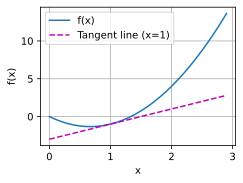

In [49]:
x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])